In [71]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"antonio99","key":"9c4bb152f496158c8608a587dd77af5c"}'}

In [72]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d shivamb/bank-customer-segmentation
! unzip bank-customer-segmentation

mkdir: cannot create directory ‘/root/.kaggle’: File exists
bank-customer-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bank-customer-segmentation.zip
replace bank_transactions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bank_transactions.csv   


In [111]:
import pandas as pd
from datetime import datetime
from datetime import date
import numpy as np
import matplotlib.pyplot as plt

In [94]:
df = pd.read_csv('bank_transactions.csv')

We start by converting dates into datetime

In [95]:
df.CustomerDOB = pd.to_datetime(df.CustomerDOB)
df.TransactionTime = df.TransactionDate.apply(str) + ' ' + df.TransactionTime.apply(lambda x: str(x).zfill(6))
df.TransactionTime = df.TransactionTime.apply(lambda x: datetime.strptime(x, '%d/%m/%y %H%M%S'))
df = df.drop('TransactionDate', axis=1)

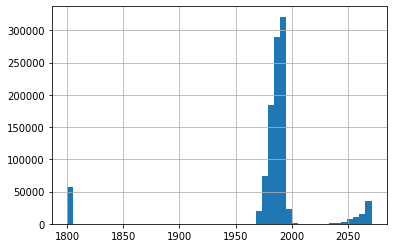

In [96]:
#then we look at the distribution of years of birth
df.CustomerDOB.apply(lambda x: x.year).hist(bins=50)

There are two problems:


*   there are years around 2050 that are generated by the conversion we just made, for example 57 is read like 2057 instead of 1957 (sort of a millunium bug). We fix this by shifting by 100 the years above 2000.
*   there are dates around 1800, clearly an error in the dataset itself, we substitute them with the date y_mode/01/01, where y_mode is the mode of the years



In [97]:
# resolve millenium bug
df.CustomerDOB = df.CustomerDOB.apply(lambda x: date(x.year - 100, x.month, x.day) if x.year > 2000  else x)
# replace dates 1800 with mode
df.loc[df.CustomerDOB.dt.year < 1900, 'CustomerDOB'] = datetime(df[df.CustomerDOB.dt.year > 1900].CustomerDOB.dt.year.mode(), 1,1)

We now look at the null values

In [98]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

We fill the CustomerDOB with the mode as we did before

In [99]:
# fill NA with mode
df.CustomerDOB = df.CustomerDOB.fillna(datetime(df[df.CustomerDOB.dt.year > 1920].CustomerDOB.dt.year.mode(), 1,1))

We fill the gender with the mode as well

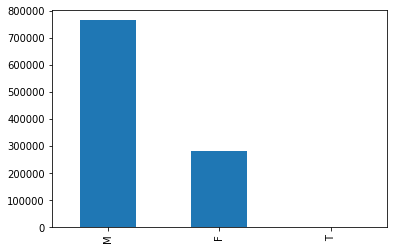

In [100]:
df.CustGender.value_counts().plot(kind='bar')

The mode is clearly male. \\
We notice that there is a third gender denoted as T, maybe indicating a transgender person, since it correspond to only one record we decide to drop it.


In [101]:
df.CustGender.value_counts()

M    765530
F    281936
T         1
Name: CustGender, dtype: int64

In [102]:
df[df.CustomerID == 'C3380368'] # see if there are others records with customer id corresponding to T

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR)
959987,T959988,C3380368,1990-01-01,T,CHENNAI,50050.0,2016-09-10 17:07:31,32500.0


In [103]:
# fill NA with Male
df.CustGender = df.CustGender.fillna('M')
# drop T
df = df.drop(df[df['CustGender'] == 'T'].index)

We fill the remaining two again with mode and mean.

In [104]:
df.CustLocation = df.CustLocation.fillna(df.CustLocation.mode().values[0])

In [105]:
df.CustAccountBalance = df.CustAccountBalance.fillna(df.CustAccountBalance.mean())

In [117]:
# # save
# df.to_csv('/content/drive/MyDrive/ADM/Homework4/df.csv')